In [1]:
# !conda activate mvTCR
# !pip install mvtcr
# !conda install nb_conda_kernels -y

In [2]:
# !pwd

/ihome/ylee/yiz133/Code/mvTCR


In [3]:
# !pip install scirpy==0.11

Defaulting to user installation because normal site-packages is not writeable


In [4]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os 
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import scirpy as ir
import anndata as ann

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

sc.settings.verbosity = 3


In [5]:
ir.__version__

'0.11.0'

In [6]:
sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 3
sc.settings.n_jobs = 3
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)

Paths to preprocessed data at different stages.

In [7]:
path_base = './data/'
path_merged = path_base + 'merged_tcr_10x.h5ad'
path_filtered = path_base + 'filtered_tcr_10x.h5ad'
path_logged = path_base + 'logged_10x.h5ad'
path_highlyvar = path_base + 'highly_var_5000.h5ad'
path_clean_split = path_base + 'v5_train_val_test.h5ad'
path_supervised = path_base + 'v6_supervised.h5ad'
path_avidity = path_base + 'v7_avidity.h5ad'

## Merge Files

The 10x VDJ dataset consists of CD8+ T cells from for donor. First, transcriptome data is merged with tcr information. In a second step, the data is fused over all donors. In the third step, the measured binding affinity is merged.

In [67]:
adatas = []
batch_names = []
# for i in range(4,5):

i = 4

# Transcriptome data
file_name = path_base + f'patient_{i}/vdj_v1_hs_aggregated_donor{i}_filtered_feature_bc_matrix.h5'
adata_tmp = sc.read_10x_h5(file_name)

# TCR data
path_anno = path_base + f'patient_{i}/vdj_v1_hs_aggregated_donor{i}_all_contig_annotations.csv'
anno_tcr = ir.io.read_10x_vdj(path_anno)    
ir.pp.merge_with_ir(adata_tmp, anno_tcr)

# mdata = MuData({"gex": adata, "airr": adata_ir})

# Binding data
path_binding = path_base + f'patient_{i}/vdj_v1_hs_aggregated_donor{i}_binarized_matrix.csv'
binarized_matrix = pd.read_csv(path_binding, sep=',', header=0)

for k in binarized_matrix.columns:
    adata_tmp.obs[k] = None
    adata_tmp.obs.loc[binarized_matrix['barcode'].values, k] = binarized_matrix[k].values
    adata_tmp.obs[k] = adata_tmp.obs[k].astype(str)

adata_tmp.var_names_make_unique()
adatas.append(adata_tmp)
batch_names.append(f'donor_{i}')
      
adata = adatas[0].concatenate(adatas[1:], batch_key='donor', batch_categories=batch_names)

for c in adata.obs.columns:
    if c.startswith('CD') or c.startswith('Ig') or c.startswith('HLA'):
        adata.obs[c] = adata.obs[c].astype(str)

sc.write(adata=adata, filename=path_merged)

reading ./data/patient_4/vdj_v1_hs_aggregated_donor4_filtered_feature_bc_matrix.h5
 (0:00:01)


/ihome/ylee/yiz133/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/ihome/ylee/yiz133/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/ihome/ylee/yiz133/.local/lib/python3.11/site-packages/scirpy/io/_io.py:199: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


/scratch/slurm-4577069/ipykernel_28650/556784513.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata_tmp.obs[k] = None
/scratch/slurm-4577069/ipykernel_28650/556784513.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata_tmp.obs[k] = None
/scratch/slurm-4577069/ipykernel_28650/556784513.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a 

In [68]:
adata

AnnData object with n_obs × n_vars = 36619 × 33538
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'barcode', 'donor

In [9]:
count_irs = sum([1 for x in adata.obs['has_ir'] if x=='True'])
print(f'Total Count: {len(adata.obs)}')
print(f'With IR-Info: {count_irs}')

Total Count: 36619
With IR-Info: 27308


In [10]:
# 237883
adata.obs['donor'].value_counts()

donor
donor_4    36619
Name: count, dtype: int64

# Qualitiy control

Load data and calculate the amount of counts, genes and fraction of mitochondrial genes.

In [11]:
adata = sc.read(path_merged)
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])

adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
mt_gene_index = np.where(mt_gene_mask)[0]
adata.obs['mt_fraction'] = adata.X[:, mt_gene_index].sum(1) / adata.X.sum(1)

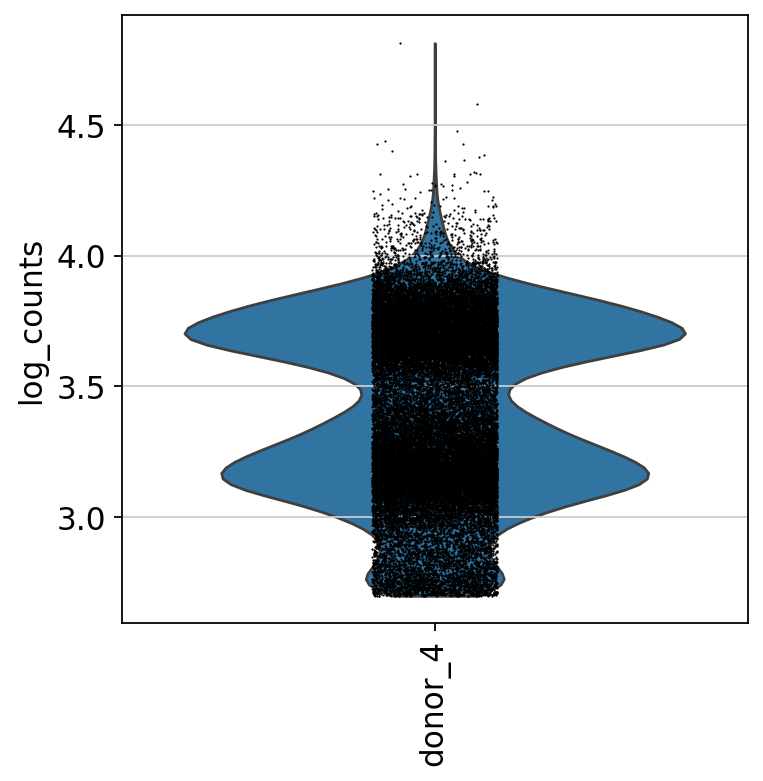

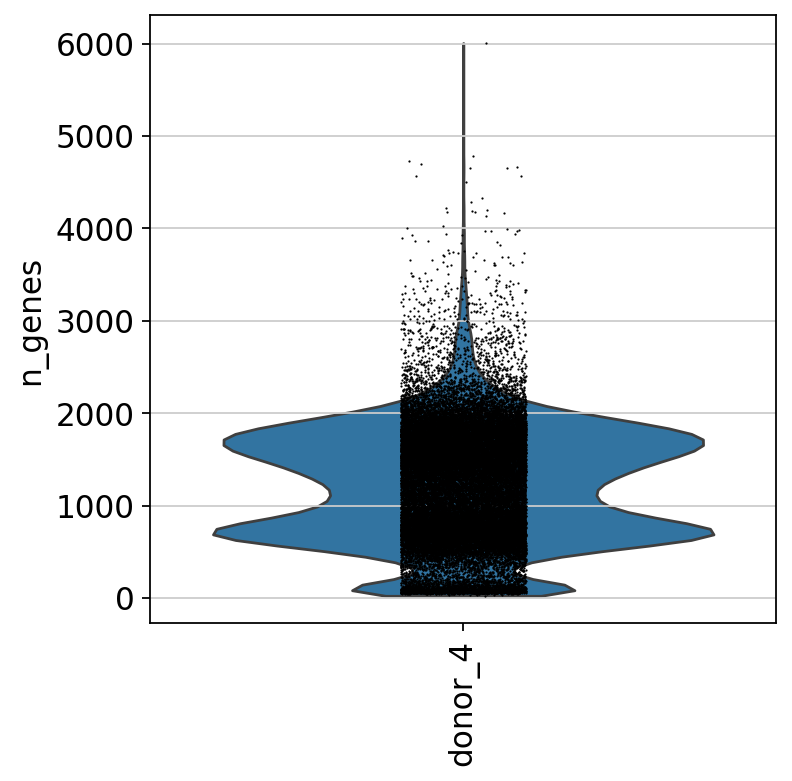

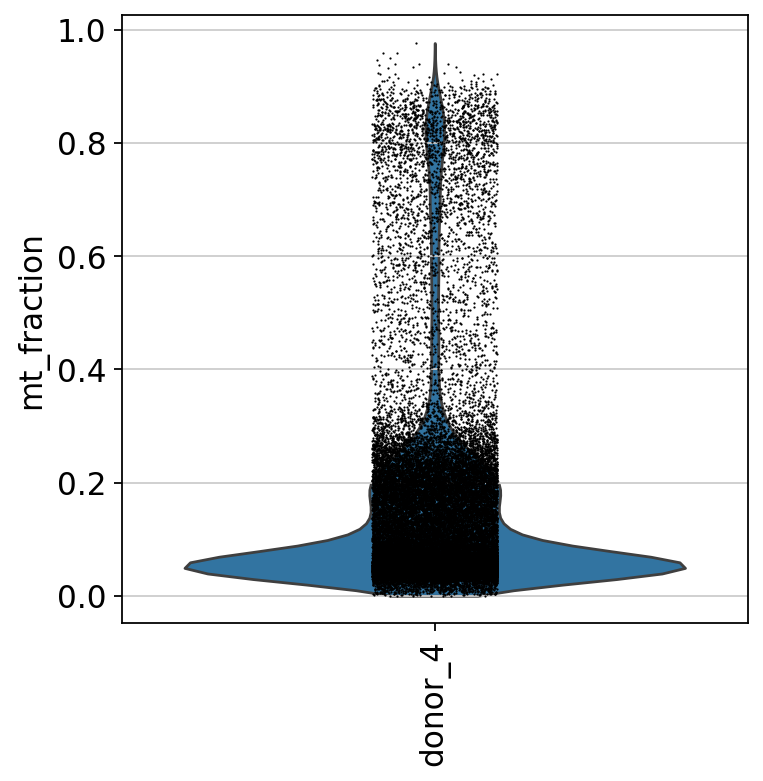

In [12]:
rcParams['figure.figsize'] = (5, 5)
sc.pl.violin(adata, ['log_counts'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata, ['n_genes'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata, ['mt_fraction'], groupby='donor', size=1, log=False, rotation=90)

<Axes: title={'center': 'mt fraction'}, xlabel='n_counts', ylabel='n_genes'>

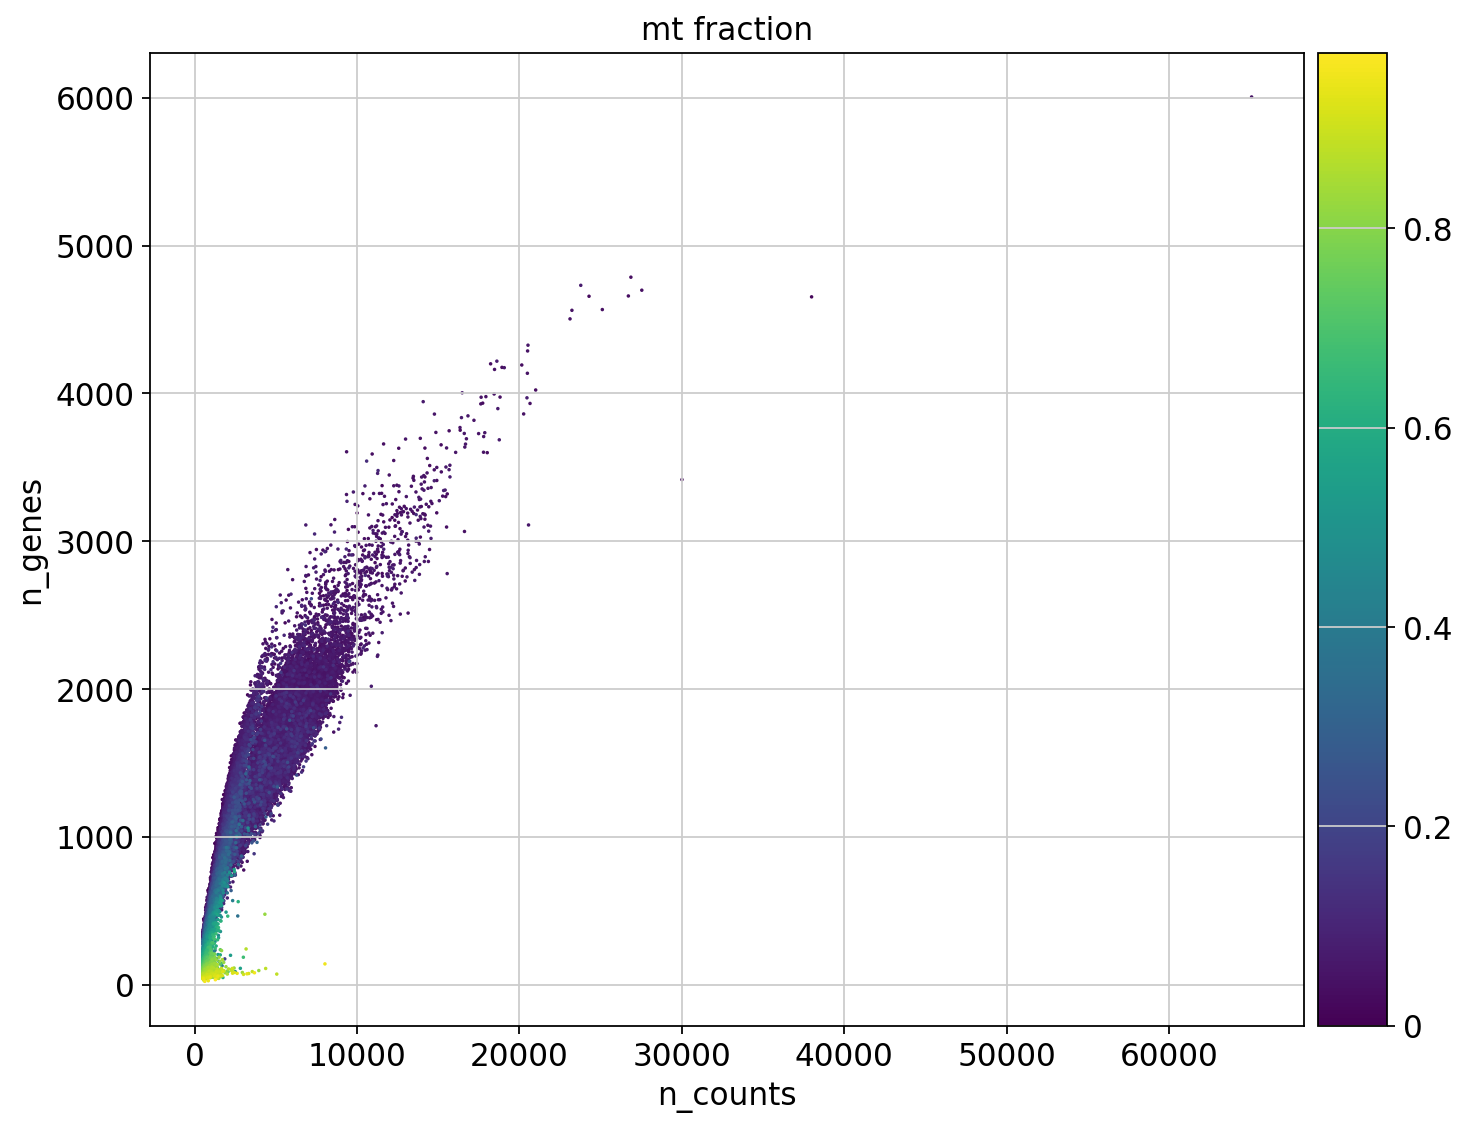

In [13]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.scatter(adata, y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)

<Axes: title={'center': 'donor'}, xlabel='n_counts', ylabel='n_genes'>

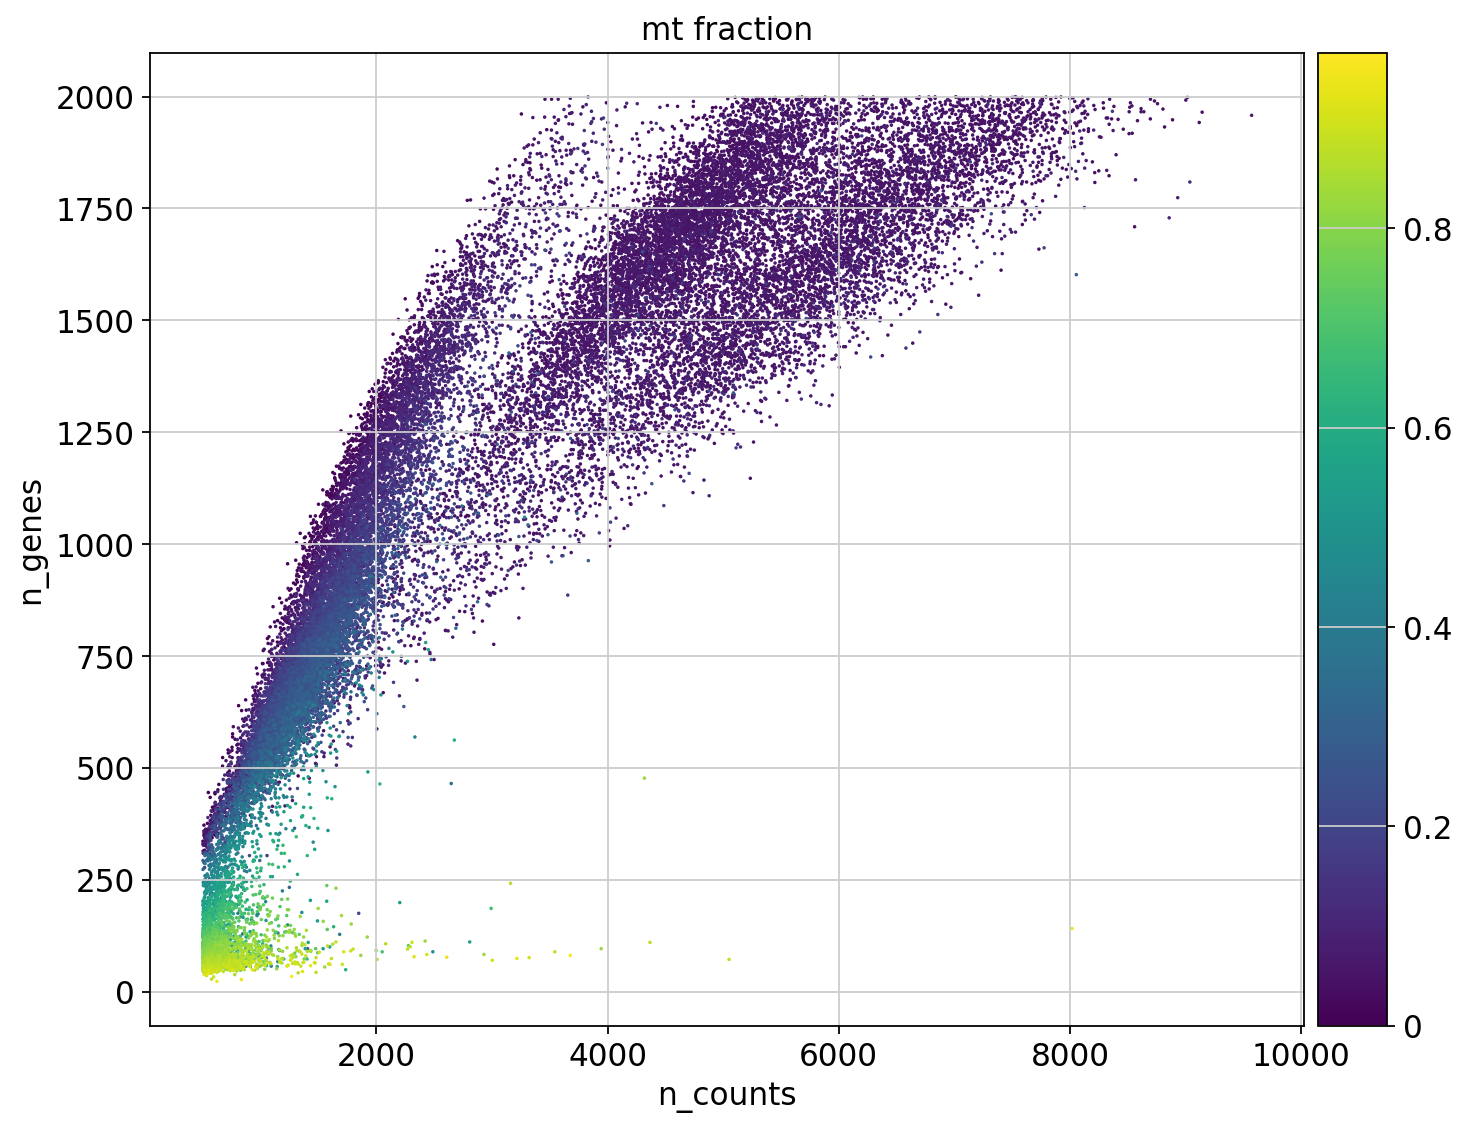

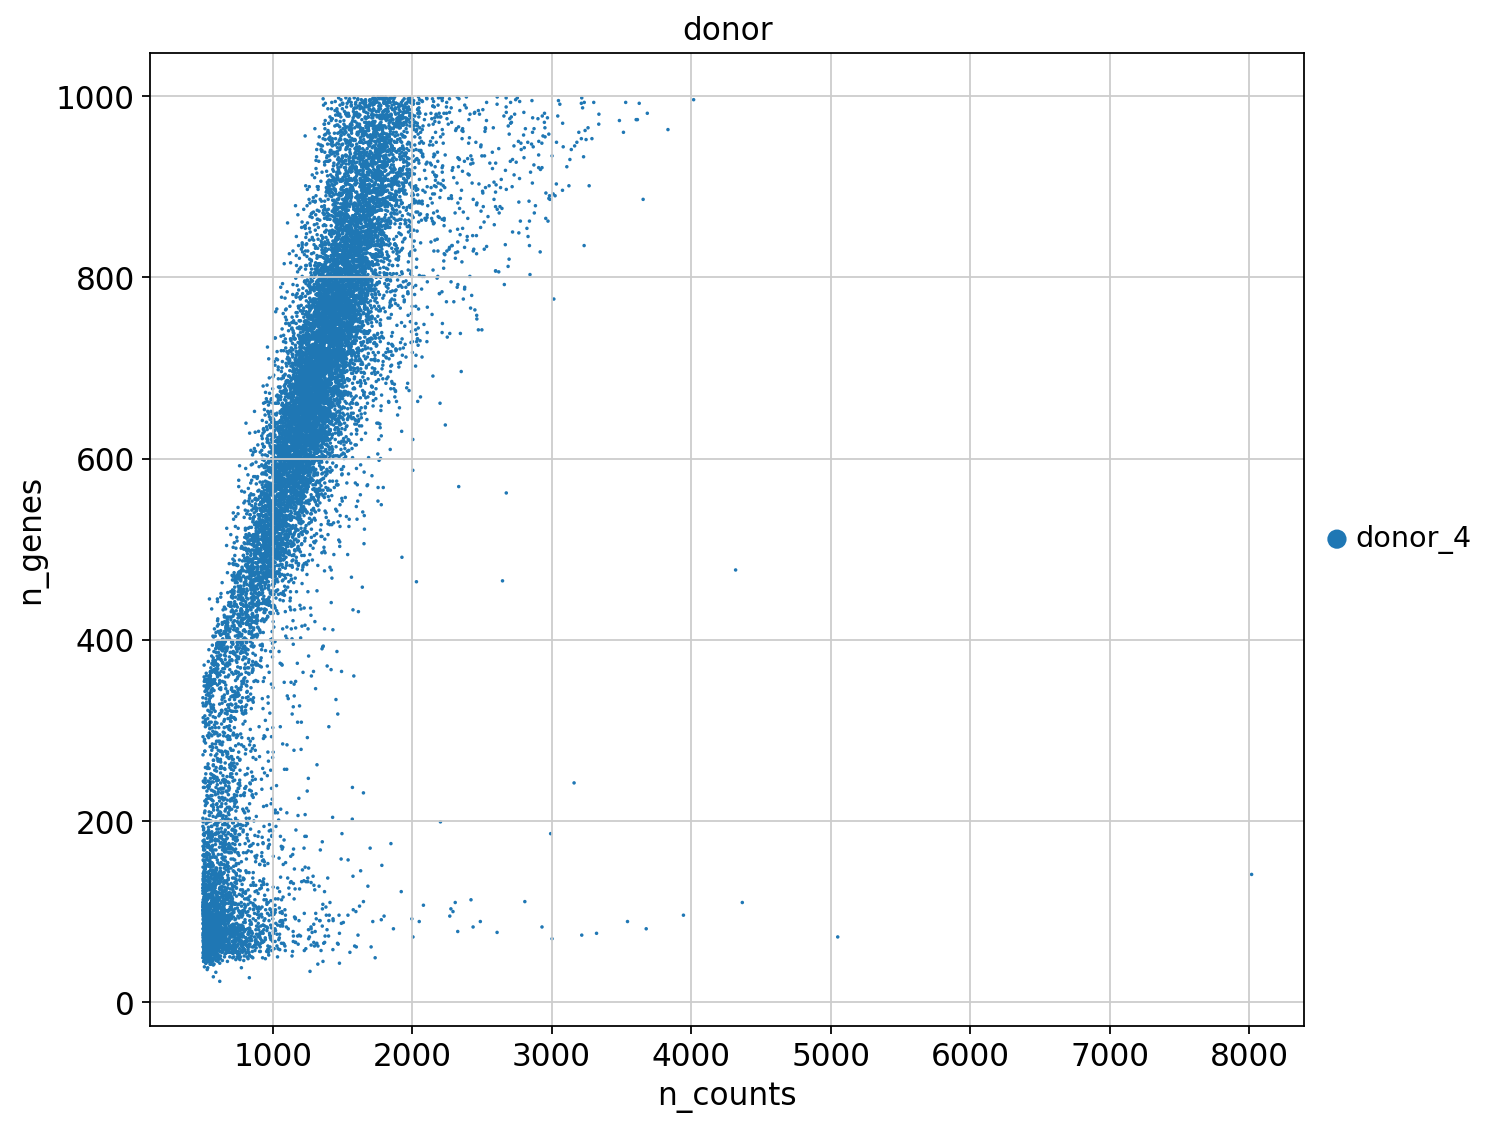

In [14]:
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<2000, adata.obs['n_counts']<10000)],
             y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<1000, adata.obs['n_counts']<10000)],
             y='n_genes', x='n_counts', color='donor', size=10, show=False)

## Cell Filtering

Filter cells by the following indicators:
- fraction of mitochondrial genes (max)
- gene count (min, max)
- gene count (max)

Filter genes by:
- amount of cells representing this gene (min)


Mitochondrial filter: The fraction of mt genes to all genes is high for cell with membrane leakage.

In [15]:
adata_tmp = adata.copy()
print(f'Total number of cells: {adata_tmp.n_obs}')
high_mt = adata_tmp.obs['mt_fraction'] < 0.2  #todo why this value
adata_tmp = adata_tmp[high_mt]
print(f'Number of cells after MT filter: {adata_tmp.n_obs}')

Total number of cells: 36619
Number of cells after MT filter: 28405


Gene-Count Filter between 1000 and 10.000

In [16]:
low_count = adata_tmp.obs['n_counts'] > 1000
adata_tmp = adata_tmp[low_count]
print(f'Number of cells after minimum count filter: {adata_tmp.n_obs}')

sc.pp.filter_cells(adata_tmp, max_counts=10000)
print(f'Number of cells after maximum filter: {adata_tmp.n_obs}')

Number of cells after minimum count filter: 27437
filtered out 452 cells that have more than 10000 counts
Number of cells after maximum filter: 26985


/ihome/ylee/yiz133/.local/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:164: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Gene-Count Filter: filter out cells with low gene count < 500

In [17]:
low_genes = adata_tmp.obs['n_genes'] > 500
adata_tmp = adata_tmp[low_genes]
print(f'Number of cells after minimum gene filter: {adata_tmp.n_obs}')

Number of cells after minimum gene filter: 26962


Gene-Filter: filter out genes that are represented in less than 10 cells

In [18]:
sc.pp.filter_genes(adata_tmp, min_cells=10)
print(f'Number of cells after gene filter: {adata_tmp.n_vars}')

filtered out 17840 genes that are detected in less than 10 cells


/ihome/ylee/yiz133/.local/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Number of cells after gene filter: 15698


## Doublet detection

In droplet based methods multiple cells might be present in a drop. The droplet score is evaluated by Scrublet.

In [19]:
# import scrublet as scr
import scipy.io
import time

In [20]:
adata_tmp.obs['doublet_score'] = np.zeros(adata_tmp.shape[0])
adata_tmp.obs['doublet'] = np.zeros(adata_tmp.shape[0])

In [21]:
# filtering / preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters
expected_doublet_rate = 0.02
sim_doublet_ratio = 3
n_neighbors = 15

for batch in enumerate(adata_tmp.obs['donor'].cat.categories):
    print(batch)
    t0 = time.time()
    idx = np.flatnonzero(adata_tmp.obs['donor']==batch[1])
    scrub = scr.Scrublet(counts_matrix = adata_tmp[idx, :].X,
                        n_neighbors = n_neighbors,
                        sim_doublet_ratio = sim_doublet_ratio,
                        expected_doublet_rate = expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts = min_counts,
                                                              min_cells = min_cells,
                                                              n_prin_comps = n_pc,
                                                              use_approx_neighbors = True,
                                                              get_doublet_neighbor_parents = False)
    adata_tmp.obs['doublet_score'].iloc[idx] = doublet_scores
    adata_tmp.obs['doublet'].iloc[idx] = predicted_doublets
    t1 = time.time()
    print('Elapsed time: {:.1f} seconds'.format(t1-t0))

(0, 'donor_4')


NameError: name 'scr' is not defined

/scratch/slurm-4577069/ipykernel_28650/2925860125.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(adata_tmp.obs['doublet_score'], bins=100, kde=False)


<Axes: xlabel='doublet_score'>

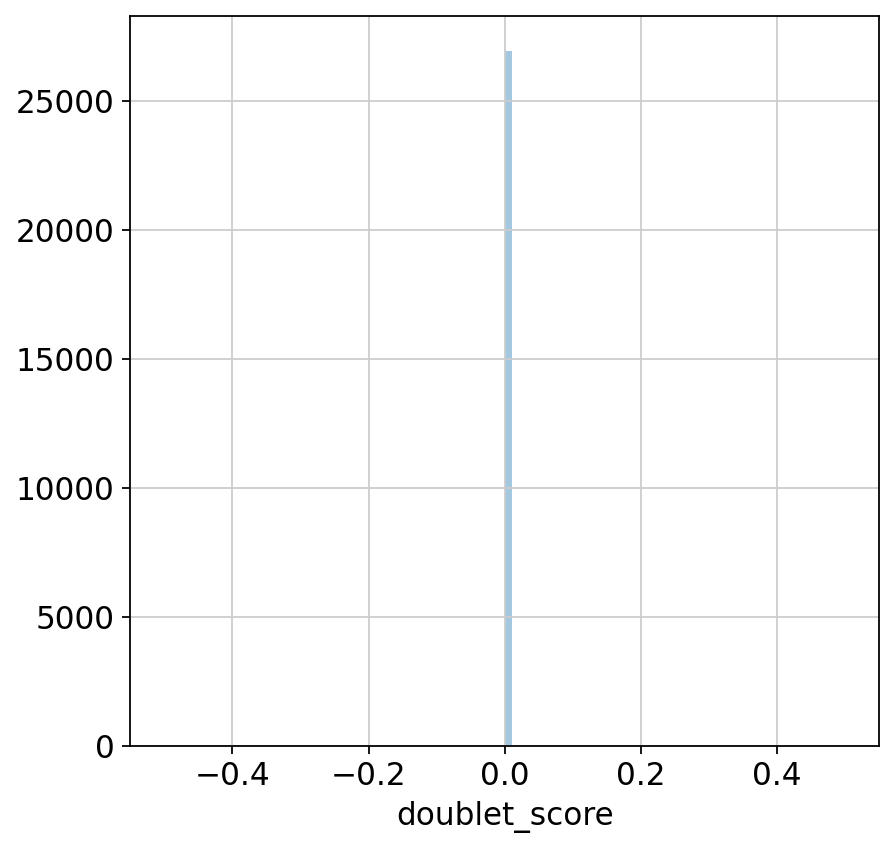

In [22]:
rcParams['figure.figsize'] = (6, 6)
sb.distplot(adata_tmp.obs['doublet_score'], bins=100, kde=False)

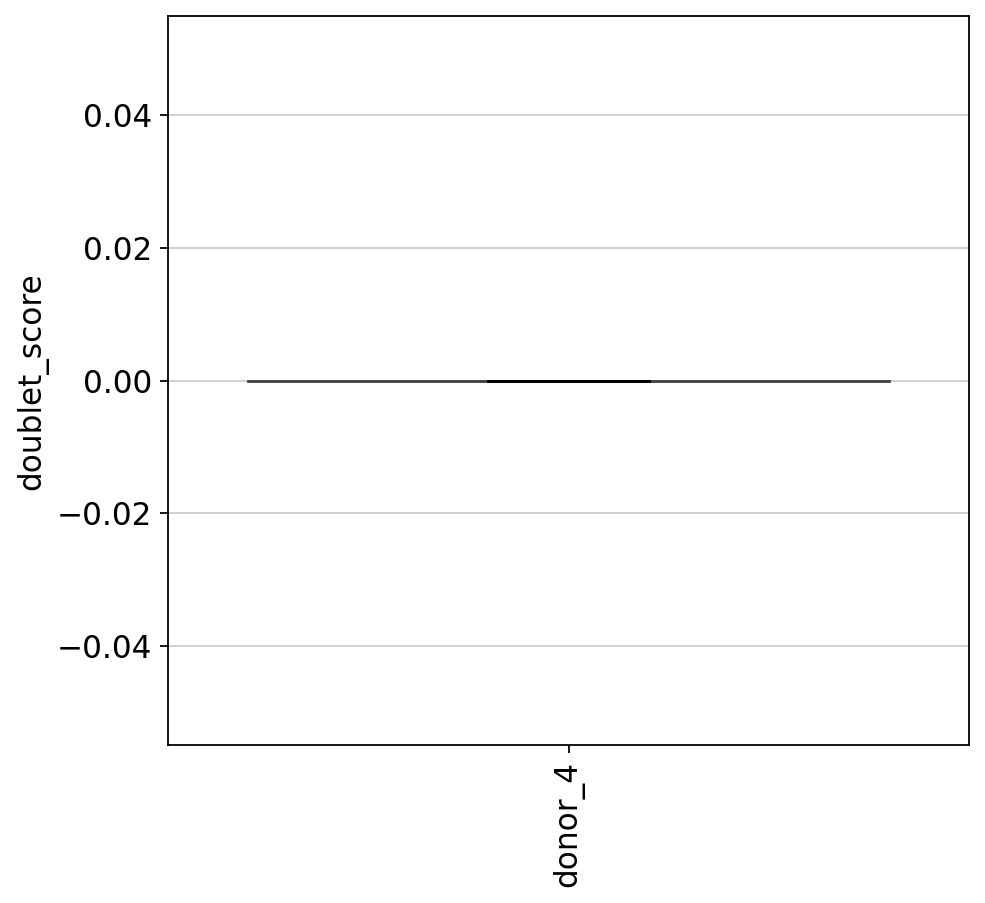

In [23]:
sc.pl.violin(adata_tmp, ['doublet_score'], groupby='donor', size=1, log=False, rotation=90)

In [24]:
thr = 0.05
idx_filter = adata_tmp.obs['doublet_score'] <= thr

adata_tmp = adata_tmp[idx_filter].copy()
print(f'Number of cells after double filter: {adata_tmp.n_obs}')

Number of cells after double filter: 26962


## QC after filtering

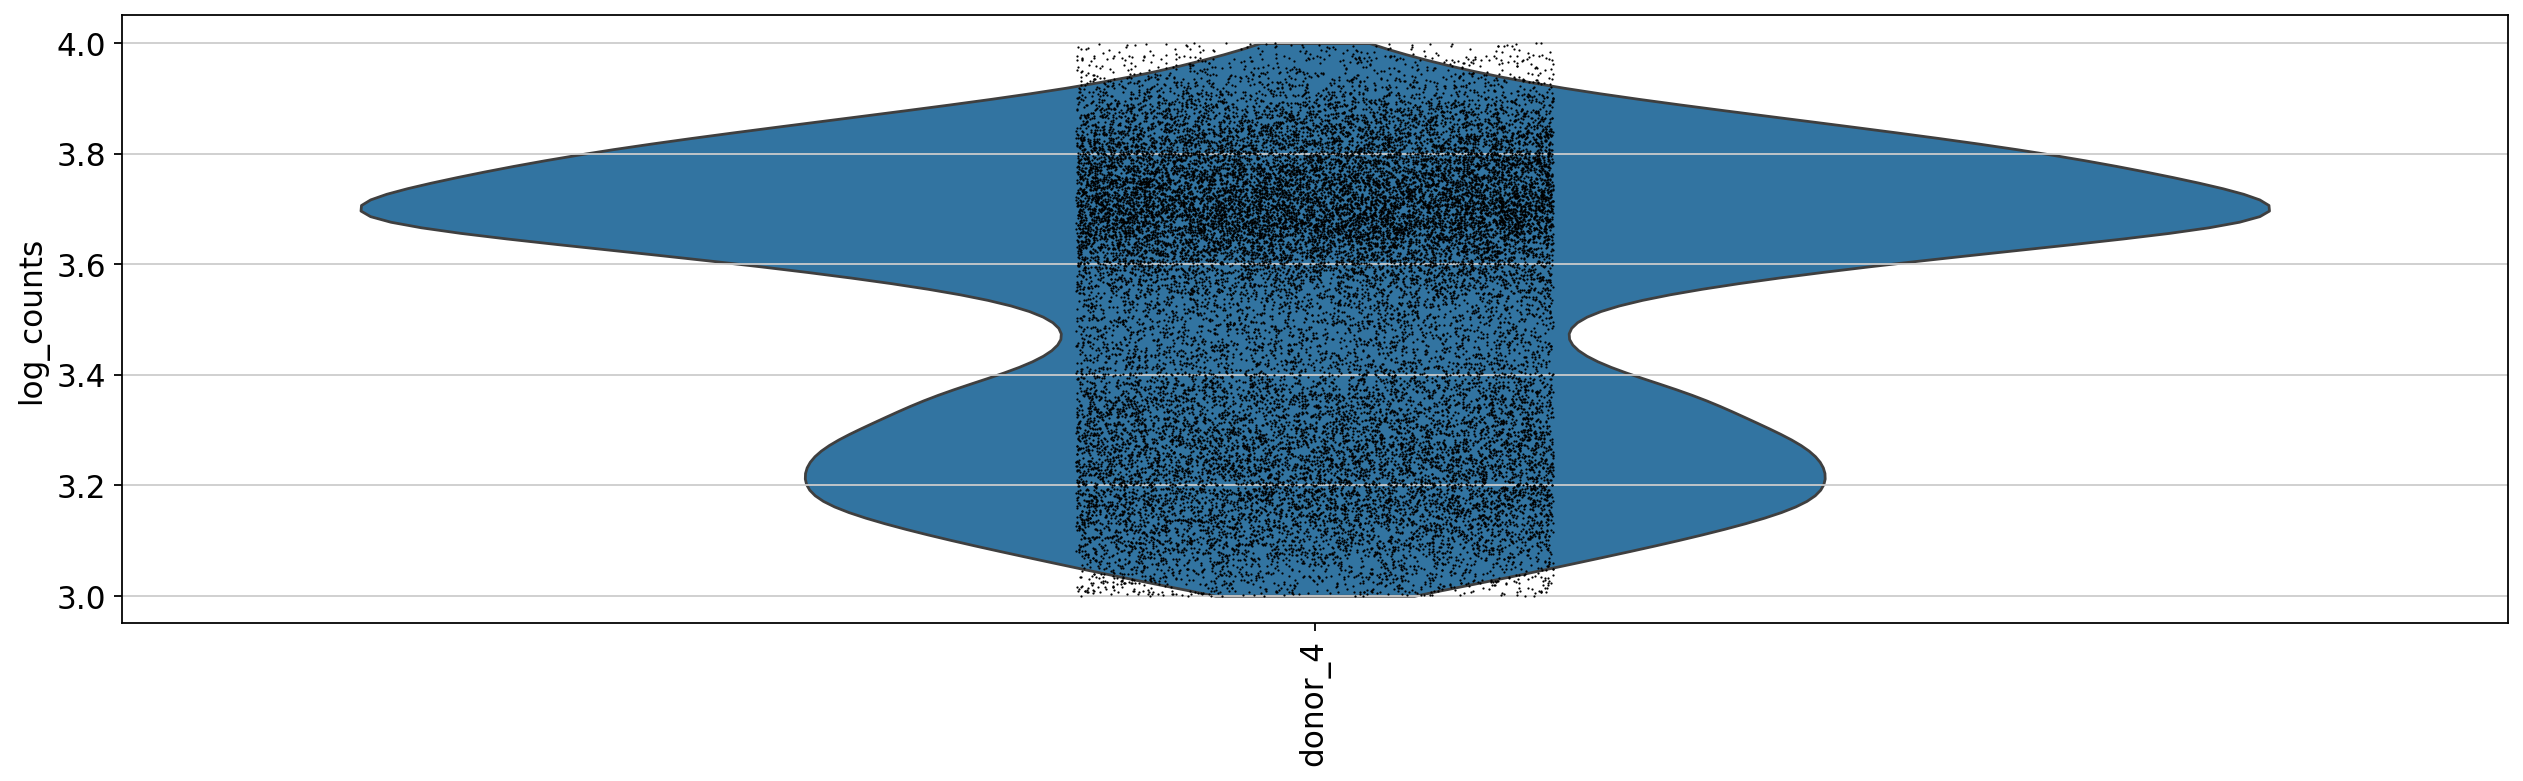

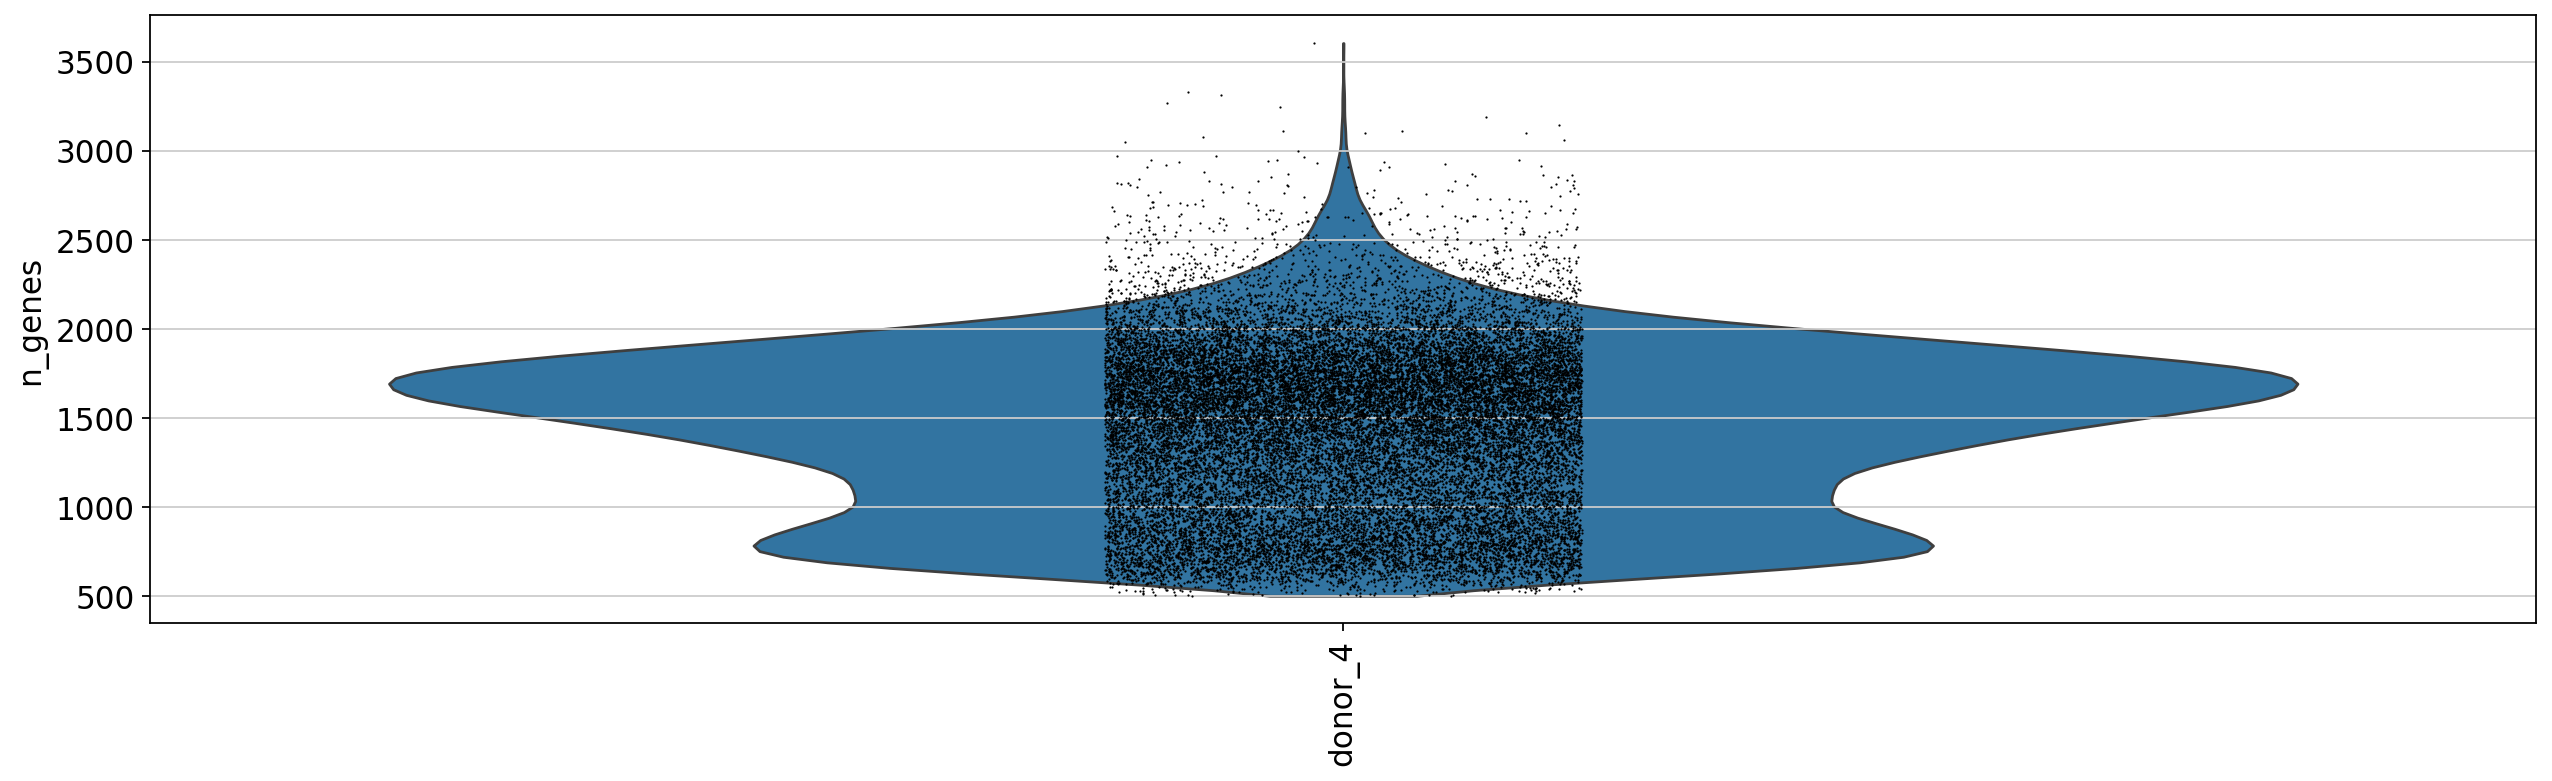

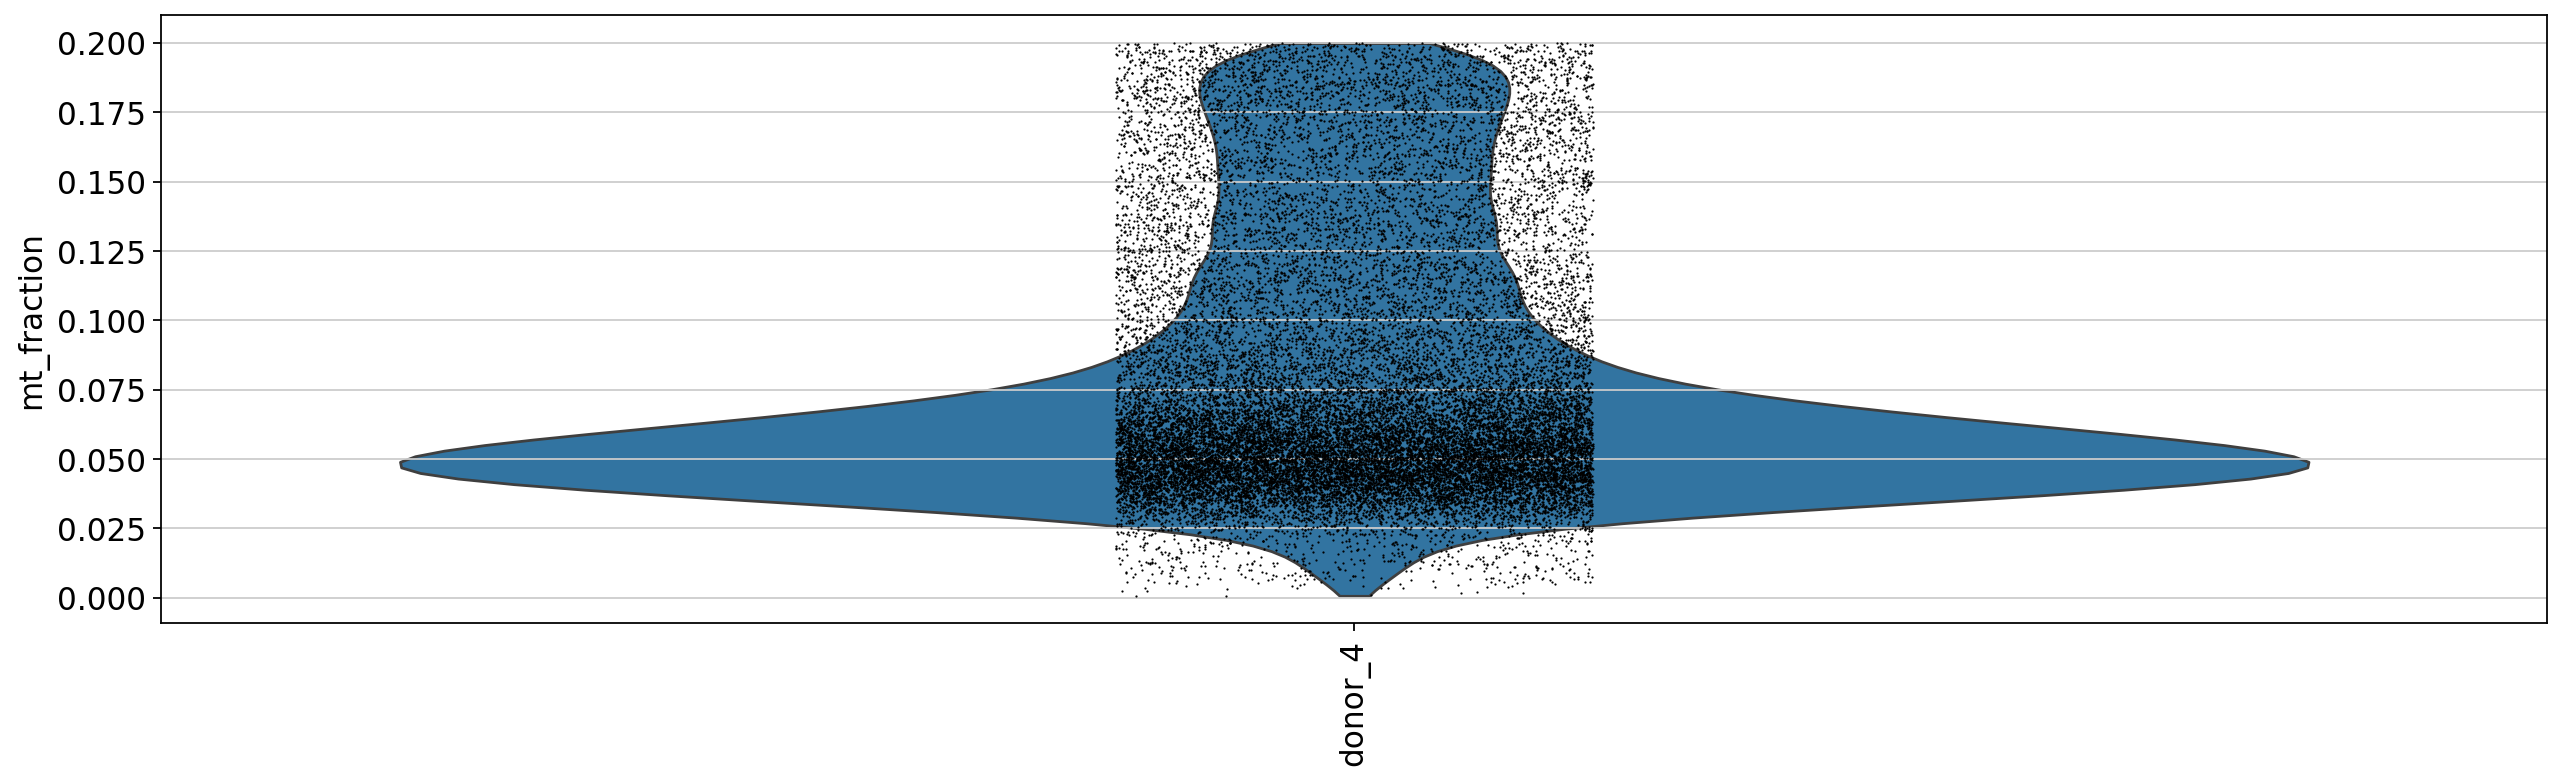

In [25]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata_tmp, ['log_counts'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata_tmp, ['n_genes'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata_tmp, ['mt_fraction'], groupby='donor', size=1, log=False, rotation=90)

In [26]:
df = adata_tmp.obs[['n_genes', 'n_counts', 'donor']]
df_all = pd.DataFrame(df.groupby(by='donor')['n_genes'].apply(np.mean).values, 
                      index=df.groupby(by='donor')['n_genes'].apply(np.mean).index, 
                      columns=['mean_genes'])

df_all['median_genes'] = df.groupby(by='donor')['n_genes'].apply(np.median).values
df_all['mean_counts'] = df.groupby(by='donor')['n_counts'].apply(np.mean).values
df_all['median_counts'] = df.groupby(by='donor')['n_counts'].apply(np.median).values
df_all

,mean_genes,median_genes,mean_counts,median_counts
donor,,,,
donor_4,1435.088235,1494.0,4007.02832,4123.0


In [27]:
adata_tmp.obs['doublet'] = adata_tmp.obs['doublet'].astype(str)

In [28]:
sc.write(adata=adata_tmp, filename=path_filtered)

## Simple normalization


In [29]:
adata_tmp = sc.read(path_filtered)

In [30]:
sc.pp.normalize_total(adata_tmp, target_sum=1e4)  # target sum? 
sc.pp.log1p(adata_tmp)

normalizing counts per cell
    finished (0:00:00)


In [31]:
sc.write(adata=adata_tmp, filename=path_logged)

## Highly variable Gens

In [32]:
adata_tmp = sc.read(path_logged)

In [33]:
adata_tmp.uns['log1p'] = {'base': None}
sc.pp.highly_variable_genes(adata_tmp, n_top_genes=5000, batch_key='donor')
print('Shape before: ', adata_tmp.shape)
adata_tmp = adata_tmp[:, adata_tmp.var['highly_variable']]
print('Shape after: ', adata_tmp.shape)

extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Shape before:  (26962, 15698)
Shape after:  (26962, 5000)


In [34]:
sc.write(adata=adata_tmp, filename=path_highlyvar)

## Model Specific Preproccessing


### Further TC cleaning

Clean cells without or multiple IR information. Filter out chains without paired TRA and TRB (None).

In [35]:
adata = sc.read_h5ad(path_highlyvar)

In [62]:
adata

AnnData object with n_obs × n_vars = 21431 × 5000
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'barcode', 'donor'

In [36]:
print('All cells: ', adata.shape)
adata = adata[adata.obs['has_ir'] == 'True']
print('With IRs: ', adata.shape)
adata = adata[adata.obs['multi_chain'] == 'False']
print('With 1 IR set: ', adata.shape)
adata = adata[(adata.obs['IR_VJ_1_junction_aa'] != 'None') & (~adata.obs['IR_VJ_1_junction_aa'].isna()) & 
              (adata.obs['IR_VDJ_1_junction_aa'] != 'None') & (~adata.obs['IR_VDJ_1_junction_aa'].isna())]
print('With full IR:', adata.shape)

All cells:  (26962, 5000)
With IRs:  (23490, 5000)
With 1 IR set:  (23430, 5000)
With full IR: (21431, 5000)


### Clonotype annotation

The clonotype annotation from 10x defines clonotypes not accross all donors. Therefor, public TCRs might leak between training and testing data. Further, cells with the same TCR but multiple IRs are classified as different clonotypes. We therefor assign own clonotype labels based on complete correspondence based on alpha and beta chain.

In [37]:
adata.obs['TRA+TRB'] = adata.obs['IR_VJ_1_junction_aa'].astype(str) + '+' + adata.obs['IR_VDJ_1_junction_aa'].astype(str)
clono_dict = {clone: idx for idx, clone in enumerate(adata.obs['TRA+TRB'].unique())}
adata.obs['clonotype'] = adata.obs['TRA+TRB'].map(clono_dict)
print(len(adata.obs['clonotype'].unique()))
adata.obs['clonotype'].head()

11326


/scratch/slurm-4577069/ipykernel_28650/3814546318.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['TRA+TRB'] = adata.obs['IR_VJ_1_junction_aa'].astype(str) + '+' + adata.obs['IR_VDJ_1_junction_aa'].astype(str)


AAACCTGCAGGTTTCA-1-donor_4    0
AAACCTGCATCAGTAC-1-donor_4    1
AAACCTGTCTACCAGA-1-donor_4    2
AAACGGGAGCCGGTAA-1-donor_4    2
AAACGGGCAGAGTGTG-1-donor_4    3
Name: clonotype, dtype: int64

In [60]:
adata.obs['TRA+TRB'].head(20)

AAACCTGCAGGTTTCA-1-donor_4          CAVEPLYGNKLVF+CATSDRLAGGELFF
AAACCTGCATCAGTAC-1-donor_4          CAYITQGGSEKLVF+CASHDLYQETQYF
AAACCTGTCTACCAGA-1-donor_4       CAVDLMKTSYDKVIF+CASRTGLASTDTQYF
AAACGGGAGCCGGTAA-1-donor_4       CAVDLMKTSYDKVIF+CASRTGLASTDTQYF
AAACGGGCAGAGTGTG-1-donor_4        CAMSRGGGADGLTF+CASSTPGQGAGEQFF
AAACGGGGTGCAGACA-1-donor_4          CAPRGHNDYKLSF+CASSLTGGEETQYF
AAACGGGGTTGTGGAG-1-donor_4     CAMREGANTNAGKSTF+CASSQDRRDSHQPQHF
AAACGGGTCGACAGCC-1-donor_4       CAMKGGGSNYKLTF+CASSAHRGGQGNEQFF
AAAGATGCAAGAAAGG-1-donor_4         CAVPSNRDDKIIF+CASSFGTGIRSEQYF
AAAGATGCACGTGAGA-1-donor_4       CVVSLLMDSNYQLIW+CSARRSGTDVWEQYF
AAAGATGGTTGTTTGG-1-donor_4    CAVRPPPSSGGYQKVTF+CASRGSGTSSVYEQYF
AAAGATGTCGAACGGA-1-donor_4          CAPLGTGGFKTIF+CASSDEIPNTEAFF
AAAGATGTCGTGGACC-1-donor_4            CAVMDSNYQLIW+CASSDTSYNEQFF
AAAGCAAGTCTTCTCG-1-donor_4        CAMSRGGGADGLTF+CASSTPGQGAGEQFF
AAAGCAATCCGAATGT-1-donor_4       CAVDLMKTSYDKVIF+CASRTGLASTDTQYF
AAAGTAGGTCGTTGTA-1-donor_

### Embed Proteins

Append both chains, add start ('<'), stop ('>') and seperator ('+') token. For training purpose IR data might be needed as one hot vector.

In [38]:
import sys
sys.path.append('../mvTCR')
import tcr_embedding.utils_preprocessing as utils

ModuleNotFoundError: No module named 'tcr_embedding'

In [39]:
adata.obs['TRA+TRB'] = adata.obs['IR_VJ_1_junction_aa'].astype(str) + '+' + adata.obs['IR_VDJ_1_junction_aa'].astype(str)
pad = adata.obs['TRA+TRB'].str.len().max()
pad = int(pad)
pad

41

In [40]:
aa_to_id = {'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13,
            'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '+': 21, '<': 22, '>': 23}
utils.aa_encoding(adata, read_col='TRA+TRB', ohe_col='one_hot', label_col='tcr_seq', length_col='seq_len', pad=pad, aa_to_id=aa_to_id, start_end_symbol=True)


NameError: name 'utils' is not defined

In [41]:
print(adata.obsm['tcr_seq'].shape)
print(adata.obsm['one_hot'].shape)
print(adata.uns['aa_to_id'])

KeyError: 'tcr_seq'

### Antigen Binding Encoding

Process the Binding Specificity to form that it easy to use during training.

In [64]:
adata.obs['A0101_VTEHDTLLY_IE-1_CMV_binder'].head(20)

AAACCTGCAGGTTTCA-1-donor_4    False
AAACCTGCATCAGTAC-1-donor_4    False
AAACCTGTCTACCAGA-1-donor_4    False
AAACGGGAGCCGGTAA-1-donor_4    False
AAACGGGCAGAGTGTG-1-donor_4    False
AAACGGGGTGCAGACA-1-donor_4    False
AAACGGGGTTGTGGAG-1-donor_4    False
AAACGGGTCGACAGCC-1-donor_4    False
AAAGATGCAAGAAAGG-1-donor_4    False
AAAGATGCACGTGAGA-1-donor_4    False
AAAGATGGTTGTTTGG-1-donor_4    False
AAAGATGTCGAACGGA-1-donor_4    False
AAAGATGTCGTGGACC-1-donor_4    False
AAAGCAAGTCTTCTCG-1-donor_4    False
AAAGCAATCCGAATGT-1-donor_4    False
AAAGTAGGTCGTTGTA-1-donor_4    False
AAATGCCCACAGACAG-1-donor_4    False
AAATGCCCACCTCGTT-1-donor_4    False
AACACGTAGCCGTCGT-1-donor_4    False
AACACGTCACGAAAGC-1-donor_4    False
Name: A0101_VTEHDTLLY_IE-1_CMV_binder, dtype: category
Categories (1, object): ['False']

In [61]:
antigen_binding_list = [x for x in adata.obs.columns if x.endswith('_binder')]
binding_matrix = (adata.obs[antigen_binding_list] == 'True').values.astype(int)
binding_matrix.shape

(21431, 50)

In [43]:
unique_value, count = np.unique(binding_matrix.sum(axis=1), return_counts=True)
for unique_value_, count_ in zip(unique_value, count):
    print(f'Cells with {unique_value_} bindings: {count_}')

Cells with 0 bindings: 17402
Cells with 1 bindings: 4029


In [44]:
label_to_binding = {label_id: antigen for label_id, antigen in enumerate(antigen_binding_list)}
label_to_binding[-1] = 'no_data'  # For cells without binding data
binding_to_label = {antigen: label_id for label_id, antigen in enumerate(antigen_binding_list)}
binding_to_label['no_data'] = -1
binding_to_label == {v: k for k, v in label_to_binding.items()}  # sanity check, if both dicts are the reverse of each other

True

In [66]:
antigen_binding_list

['A0101_VTEHDTLLY_IE-1_CMV_binder',
 'A0201_KTWGQYWQV_gp100_Cancer_binder',
 'A0201_ELAGIGILTV_MART-1_Cancer_binder',
 'A0201_CLLWSFQTSA_Tyrosinase_Cancer_binder',
 'A0201_IMDQVPFSV_gp100_Cancer_binder',
 'A0201_SLLMWITQV_NY-ESO-1_Cancer_binder',
 'A0201_KVAELVHFL_MAGE-A3_Cancer_binder',
 'A0201_KVLEYVIKV_MAGE-A1_Cancer_binder',
 'A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase_binder',
 'A0201_LLDFVRFMGV_EBNA-3B_EBV_binder',
 'A0201_LLMGTLGIVC_HPV-16E7_82-91_binder',
 'A0201_CLGGLLTMV_LMP-2A_EBV_binder',
 'A0201_YLLEMLWRL_LMP1_EBV_binder',
 'A0201_FLYALALLL_LMP2A_EBV_binder',
 'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
 'A0201_GLCTLVAML_BMLF1_EBV_binder',
 'A0201_NLVPMVATV_pp65_CMV_binder',
 'A0201_ILKEPVHGV_RT_HIV_binder',
 'A0201_FLASKIGRLV_Ca2-indepen-Plip-A2_binder',
 'A2402_CYTWNQMNL_WT1-(235-243)236M_Y_binder',
 'A0201_RTLNAWVKV_Gag-protein_HIV_binder',
 'A0201_KLQCVDLHV_PSA146-154_binder',
 'A0201_LLFGYPVYV_HTLV-1_binder',
 'A0201_SLFNTVATL_Gag-protein_HIV_binder',
 'A0201_SLYNTVATLY_

In [45]:
adata.obs['has_binding'] = binding_matrix.sum(axis=1).astype(bool)
adata.obs['has_binding'].head()

AAACCTGCAGGTTTCA-1-donor_4    False
AAACCTGCATCAGTAC-1-donor_4    False
AAACCTGTCTACCAGA-1-donor_4    False
AAACGGGAGCCGGTAA-1-donor_4    False
AAACGGGCAGAGTGTG-1-donor_4    False
Name: has_binding, dtype: bool

In [46]:
adata.obs['binding_label'] = np.argmax(binding_matrix, axis=1)
adata.obs['binding_label'][~adata.obs['has_binding']] = -1
adata.obs['binding_label'].head()

/scratch/slurm-4577069/ipykernel_28650/3710922540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['binding_label'][~adata.obs['has_binding']] = -1


AAACCTGCAGGTTTCA-1-donor_4   -1
AAACCTGCATCAGTAC-1-donor_4   -1
AAACCTGTCTACCAGA-1-donor_4   -1
AAACGGGAGCCGGTAA-1-donor_4   -1
AAACGGGCAGAGTGTG-1-donor_4   -1
Name: binding_label, dtype: int64

In [47]:
adata.obs['binding_name'] = adata.obs['binding_label'].map(label_to_binding)
adata.obs['binding_name'].head()

AAACCTGCAGGTTTCA-1-donor_4    no_data
AAACCTGCATCAGTAC-1-donor_4    no_data
AAACCTGTCTACCAGA-1-donor_4    no_data
AAACGGGAGCCGGTAA-1-donor_4    no_data
AAACGGGCAGAGTGTG-1-donor_4    no_data
Name: binding_name, dtype: object

### Test-Validation Split
We don't want to include the same clonotype in the different splits. Further we want to have the same data distribution in donor and antigen binding dimension to have faithful results.

Therefore we need stratification (similar label distribution across the sets) and grouped sampling (groups, i.e. the same clonotype is only present in one set)

In [48]:
adata.obs['donor+binding'] = adata.obs['donor'].astype(str) + '_' + adata.obs['binding_name'].astype(str)
adata.obs['donor+binding'].sample(10)

CGACCTTTCTTTAGGG-6-donor_4    donor_4_no_data
GCGAGAAAGACTTGAA-3-donor_4    donor_4_no_data
TTCCCAGTCTAACGGT-3-donor_4    donor_4_no_data
GTGTTAGTCAGAGGTG-5-donor_4    donor_4_no_data
TTCTCCTAGCTCTCGG-2-donor_4    donor_4_no_data
CAACTAGCAGGCGATA-3-donor_4    donor_4_no_data
AGGCCGTCATTACGAC-4-donor_4    donor_4_no_data
CTCGAGGCACAACTGT-5-donor_4    donor_4_no_data
CCACGGATCCCAAGAT-1-donor_4    donor_4_no_data
CCAATCCCATGCTGGC-4-donor_4    donor_4_no_data
Name: donor+binding, dtype: object

In [49]:
random_seed = 15
# Create Train-Val and Test set
train_val, test = utils.stratified_group_shuffle_split(adata.obs, stratify_col='donor+binding', group_col='clonotype', val_split=0.20, random_seed=random_seed)
# Split Train-Val into Train and Val set
train, val = utils.stratified_group_shuffle_split(train_val, stratify_col='donor+binding', group_col='clonotype', val_split=0.25, random_seed=random_seed)

NameError: name 'utils' is not defined

In [50]:
print('Train Samples: ', len(train))
print('Train Ratio: ', len(train) / len(adata.obs))
print('Val Samples: ', len(val))
print('Val Ratio: ', len(val) / len(adata.obs))
print('Test Samples: ', len(test))
print('Test Ratio: ', len(test) / len(adata.obs))

NameError: name 'train' is not defined

#### Visualize Distribution

Logarithmic scale

In [51]:
pl.figure(figsize=(15,5))
pl.hist([train['binding_name'], val['binding_name'], test['binding_name']], density=True, bins=len(train['binding_name'].unique()), label=['train', 'val', 'test'])
pl.yscale('log')
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

NameError: name 'train' is not defined

<Figure size 1200x400 with 0 Axes>

Linear scale

In [52]:
pl.figure(figsize=(15,5))
pl.hist([train['binding_name'], val['binding_name'], test['binding_name']], density=True, bins=len(train['binding_name'].unique()), label=['train', 'val', 'test'])
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

NameError: name 'train' is not defined

<Figure size 1200x400 with 0 Axes>

In [ ]:
pl.figure(figsize=(15,5))
pl.hist([train['donor'], val['donor'], test['donor']], density=True, bins=len(train['donor'].unique()), label=['train', 'val', 'test'])
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

#### Check if clonotypes are unique within each set

In [ ]:
form_train = set(train['clonotype'].tolist())
form_val = set(val['clonotype'].tolist())
form_test = set(test['clonotype'].tolist())

print('Intersection in clonotypes between two sets should be empty\n')
print('Intersection in clonotypes between train and test: ', form_train.intersection(form_test))
print('Intersection in clonotypes between train and val: ', form_train.intersection(form_val))
print('Intersection in clonotypes between val and test: ', form_val.intersection(form_test))
# print('\nSanity Check - Intersection in clonotypes between train and train: ', form_train.intersection(form_train))

#### Save resulting split

In [ ]:
adata.obs.loc[train.index, 'set'] = 'train'
adata.obs.loc[val.index, 'set'] = 'val'
adata.obs.loc[test.index, 'set'] = 'test'
adata.obs['set'].value_counts()

In [ ]:
adata.obs['set'].sample(20)

In [ ]:
adata.write_h5ad(path_clean_split, compression='gzip')

## Supervised and Semi-supervised preprocessing
Add prediction labels to adata

In [ ]:
import sys
sys.path.append('../mvTCR/')
import tcr_embedding as tcr

In [ ]:
adata = sc.read_h5ad(path_clean_split)

In [ ]:
adata.obs[['binding_name', 'binding_label']]

In [ ]:
import config.constants_10x as constants
high_count_antigens = constants.HIGH_COUNT_ANTIGENS.copy()
high_count_antigens

In [ ]:
adata.obs['high_count_binding_name'] = adata.obs['binding_name']
# Set rare antigen specificities to 'no_data'
adata.obs['high_count_binding_name'][~adata.obs['high_count_binding_name'].isin(high_count_antigens)] = 'no_data'
adata.obs['high_count_binding_name'] = adata.obs['high_count_binding_name'].astype(str)
adata.obs['high_count_binding_name'].unique()

In [ ]:
# Use this high_count_antigens list to be consistent with the order (alphabetical)
high_count_antigens += ['no_data']
specificity_to_label = {k: v for v, k in enumerate(high_count_antigens)}
label_to_specificity = {k: v for k, v in enumerate(high_count_antigens)}
adata.uns['specificity_to_label'] = specificity_to_label
adata.uns['label_to_specificity'] = label_to_specificity
specificity_to_label

In [ ]:
adata.obs['high_count_binding_label'] = adata.obs['high_count_binding_name'].map(specificity_to_label)
adata.obs['high_count_binding_label'].value_counts()

In [ ]:
aa_to_id = adata.uns['aa_to_id']
utils.aa_encoding(adata, read_col='IR_VJ_1_junction_aa', label_col='alpha_seq', length_col='alpha_len', pad=26, aa_to_id=aa_to_id, start_end_symbol=False)
utils.aa_encoding(adata, read_col='IR_VDJ_1_junction_aa', label_col='beta_seq', length_col='beta_len', pad=26, aa_to_id=aa_to_id, start_end_symbol=False)

In [ ]:
print(adata.uns.keys())
adata.uns = {}
adata.uns['aa_to_id'] = aa_to_id
adata.uns['specificity_to_label'] = specificity_to_label

In [ ]:
adata.write_h5ad(path_supervised, compression='gzip')

## Add avidity information

In [ ]:
import sys
sys.path.append('../mvTCR/')
import config.constants_10x as const

In [ ]:
adata = sc.read(path_supervised)

In [ ]:
cols_binder_counts = const.HIGH_COUNT_ANTIGENS
cols_binder_counts = ['_'.join(el.split('_')[:-1]) for el in cols_binder_counts]

In [ ]:
binding_counts = []
for donor in range(1, 5):
    path_binding = f'../mvTCR/data/10x_CD8TC/patient_{donor}/vdj_v1_hs_aggregated_donor{donor}_binarized_matrix.csv'
    binarized_matrix = pd.read_csv(path_binding, sep=',', header=0, index_col=0)
    binarized_matrix.index.name = None
    binarized_matrix = binarized_matrix[cols_binder_counts]
    binarized_matrix.index = binarized_matrix.index + f'-donor_{donor}'
    binding_counts.append(binarized_matrix)
binding_counts = pd.concat(binding_counts)

In [ ]:
binding_counts = binding_counts.loc[adata.obs.index]
adata.obsm['binding_counts'] = binding_counts.values

In [ ]:
adata.write_h5ad(path_avidity, compression='gzip')